In [51]:
!git config --global user.name "serjshul"
!git config --global user.email "shulginsergey0@gmail.com"

In [94]:
!cp "/content/drive/MyDrive/kaggle/spaceship_titanic/spaceship_titanic.ipynb" "/content/Spaceship-Titanic"

%cd /content/Spaceship-Titanic
!git add .
!git commit -m "Another test"
!git push origin main

# Spaceship Titanic

Introduction

In [96]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


In [97]:
pip install tensorflow_decision_forests

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-2.17.0:
   

In [196]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

from catboost import CatBoostClassifier

import tensorflow_decision_forests as tfdf

from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout
from keras.initializers import HeNormal
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Data loading

Read the `train` dataframe:

In [459]:
df_train = pd.read_csv('/content/drive/MyDrive/kaggle/spaceship_titanic/data/train.csv')

In [460]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [461]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Read the `test` dataframe:

In [462]:
df_test = pd.read_csv('/content/drive/MyDrive/kaggle/spaceship_titanic/data/test.csv')

In [463]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [464]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


ALso read the `sample_submission` dataframe

In [465]:
df_sample_submission = pd.read_csv('/content/drive/MyDrive/kaggle/spaceship_titanic/data/sample_submission.csv')

In [466]:
df_sample_submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


## Explaratory data analysis

There are field of the `df_train`:
- `PassengerId` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [467]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Let's destruct the `PassengerId` into `GroupNumber` and `PeopleNumber` columns and the `Cabin` into `Deck`, `Number` and `Side` columns:

In [468]:
df_train[['GroupNumber', 'PeopleNumber']] = df_train['PassengerId'].str.split('_', expand=True)
df_train.drop(columns=['PassengerId', 'Name'],inplace=True)

df_train[['Deck', 'Number', 'Side']] = df_train['Cabin'].str.split('/', expand=True)
df_train.drop('Cabin', axis=1, inplace=True)

In [469]:
df_test[['GroupNumber', 'PeopleNumber']] = df_test['PassengerId'].str.split('_', expand=True)
df_test.drop(columns=['Name'],inplace=True)

df_test[['Deck', 'Number', 'Side']] = df_test['Cabin'].str.split('/', expand=True)
df_test.drop('Cabin', axis=1, inplace=True)

Next, create `TotalBill` series that illustrates all bills in `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` and `VRDeck`:

In [470]:
df_train['TotalBill'] = df_train['RoomService'] + df_train['FoodCourt'] + df_train['ShoppingMall'] + df_train['Spa'] + df_train['VRDeck']

In [471]:
df_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,PeopleNumber,Deck,Number,Side,TotalBill
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0,P,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0,S,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0,S,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,A,0,S,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,F,1,S,1091.0


Compose the func that computes NA values all columns in a dataframe:

In [472]:
def analyze_na(df):
    na_summary = pd.DataFrame({
        'NA count': df.isna().sum(),
        'NA percentage (%)': df.isna().mean()
    })
    return na_summary

analyze_na(df_train)

,NA count,NA percentage (%)
HomePlanet,201,0.023122
CryoSleep,217,0.024963
Destination,182,0.020936
Age,179,0.020591
VIP,203,0.023352
RoomService,181,0.020821
FoodCourt,183,0.021051
ShoppingMall,208,0.023927
Spa,183,0.021051
VRDeck,188,0.021627


Take a look at unique values of the `train` and `test` dataframes:

In [473]:
print("Unique values at:")
print("1) HomePlanet")
print("       train -", (df_train['HomePlanet']).unique())
print("       test  -", (df_test['HomePlanet']).unique())
print("2) Destination")
print("       train -", (df_train['Destination']).unique())
print("       test  -", (df_test['Destination']).unique())
print("3) Deck")
print("       train -", (df_train['Deck']).unique())
print("       test  -", (df_test['Deck']).unique())
print("4) Side")
print("       train -", (df_train['Side']).unique())
print("       test  -", (df_test['Side']).unique())

Unique values at:
1) HomePlanet
       train - ['Europa' 'Earth' 'Mars' nan]
       test  - ['Earth' 'Europa' 'Mars' nan]
2) Destination
       train - ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
       test  - ['TRAPPIST-1e' '55 Cancri e' 'PSO J318.5-22' nan]
3) Deck
       train - ['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
       test  - ['G' 'F' 'C' 'B' 'D' 'E' nan 'A' 'T']
4) Side
       train - ['P' 'S' nan]
       test  - ['S' 'P' nan]


Describe counts of `CryoSleep`, `VIP` and `Transported` values:

<Axes: title={'center': 'Transported count'}, ylabel='count'>

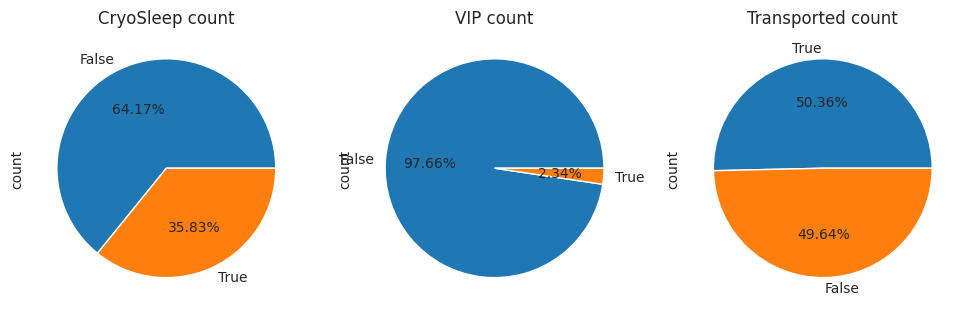

In [474]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
df_train['CryoSleep'].value_counts().plot(kind='pie', title='CryoSleep count', autopct='%1.2f%%', ax=axes[0])
df_train['VIP'].value_counts().plot(kind='pie', title='VIP count', autopct='%1.2f%%', ax=axes[1])
df_train['Transported'].value_counts().plot(kind='pie', title='Transported count', autopct='%1.2f%%', ax=axes[2])

There are the `Age` distribution

<Axes: xlabel='Age', ylabel='Count'>

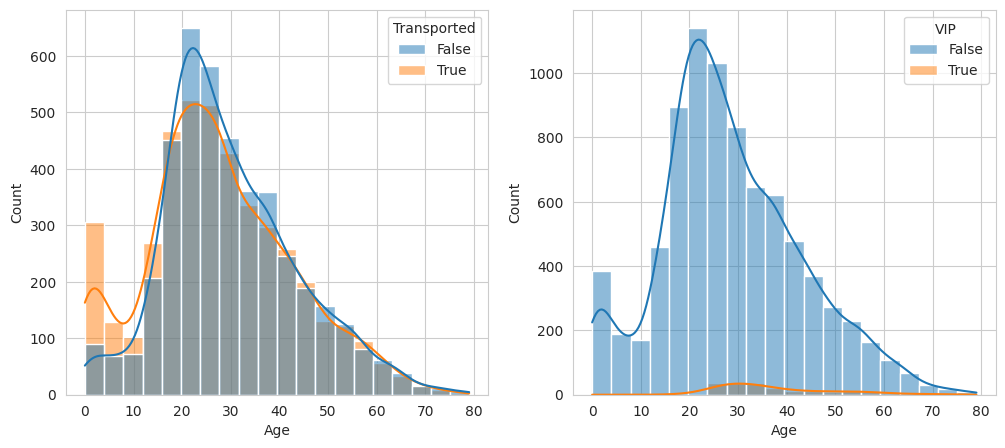

In [475]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.histplot(data=df_train, x='Age', hue='Transported', bins=20, kde=True, ax=axes[0])
sns.histplot(data=df_train, x='Age', hue='VIP', bins=20, kde=True, ax=axes[1])

Take a look at the `HomePlanet`, `Destination`, `CryoSleep` and `Transported` divided by `VIP`:

[Text(0, 0, '123'), Text(0, 0, '76')]

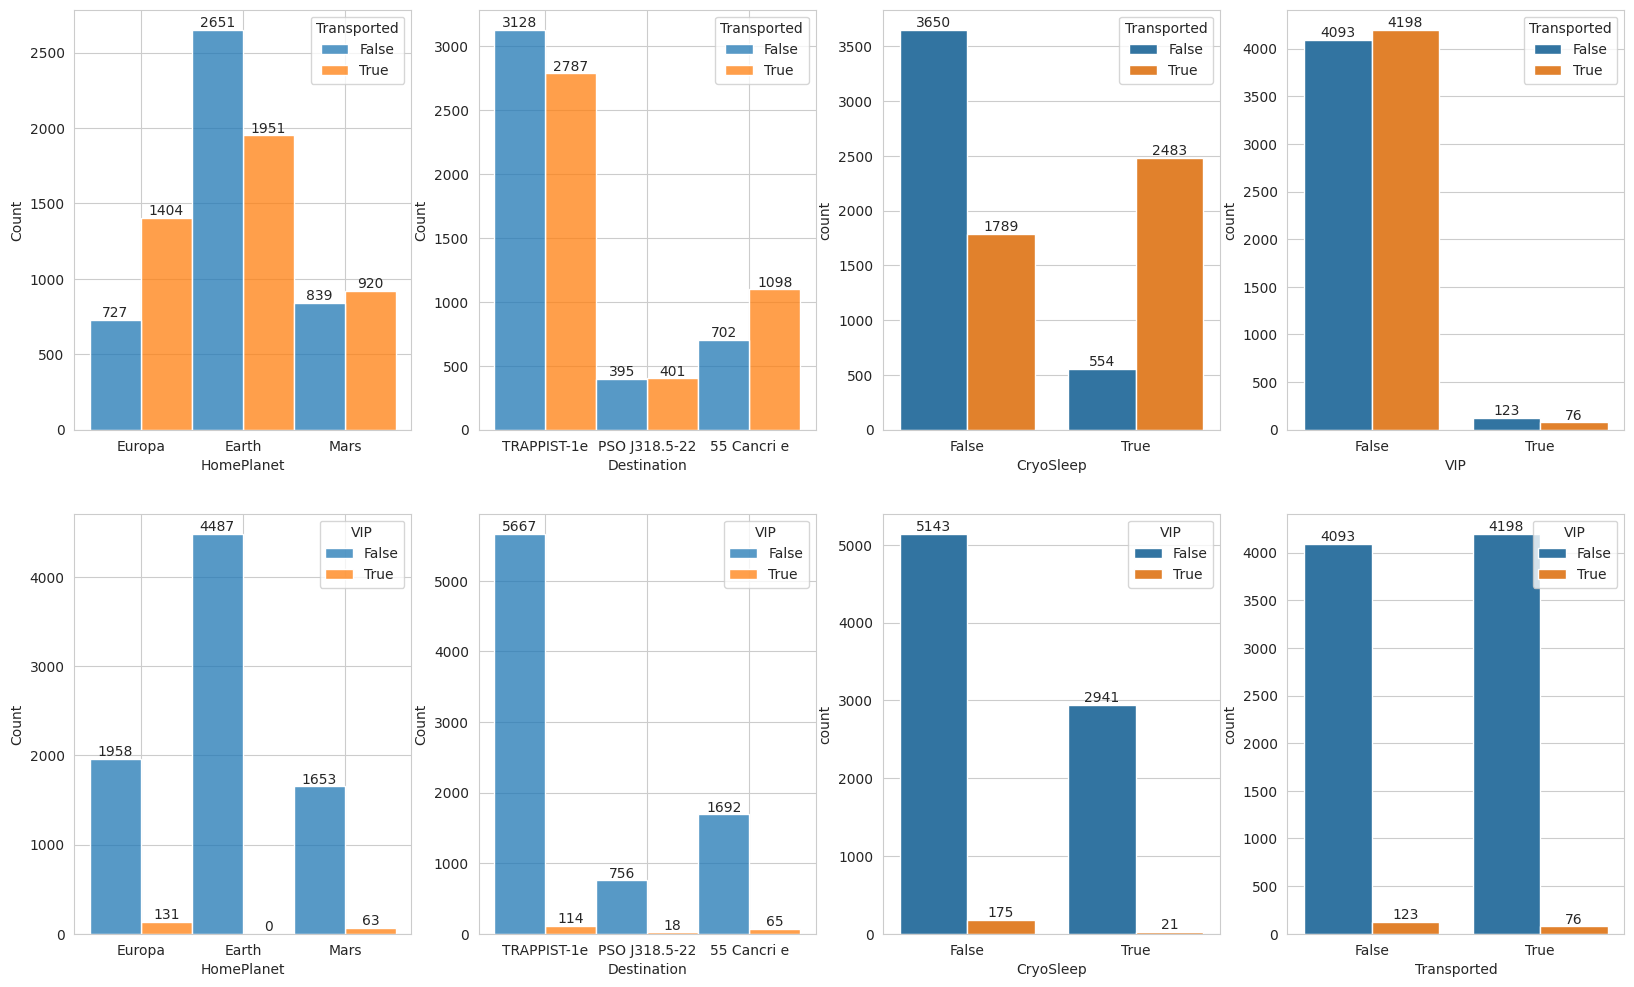

In [476]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12))
ax = sns.histplot(data=df_train, x='HomePlanet', hue='Transported', multiple="dodge", ax=axes[0][0])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax = sns.histplot(data=df_train, x='Destination', hue='Transported', multiple="dodge", ax=axes[0][1])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax = sns.countplot(data=df_train, x='CryoSleep', hue='Transported', ax=axes[0][2])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax = sns.countplot(data=df_train, x='VIP', hue='Transported', ax=axes[0][3])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax = sns.histplot(data=df_train, x='HomePlanet', hue='VIP', multiple="dodge", ax=axes[1][0])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax = sns.histplot(data=df_train, x='Destination', hue='VIP', multiple="dodge", ax=axes[1][1])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax = sns.countplot(data=df_train, x='CryoSleep', hue='VIP', ax=axes[1][2])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax = sns.countplot(data=df_train, x='Transported', hue='VIP', ax=axes[1][3])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

`TotalBill`

<Axes: xlabel='TotalBill', ylabel='Count'>

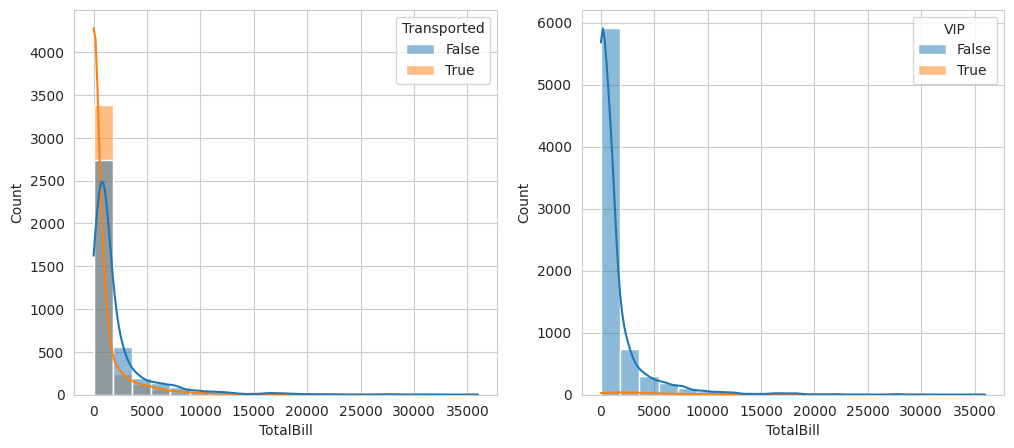

In [477]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.histplot(data=df_train, x='TotalBill', hue='Transported', bins=20, kde=True, ax=axes[0])
sns.histplot(data=df_train, x='TotalBill', hue='VIP', bins=20, kde=True, ax=axes[1])

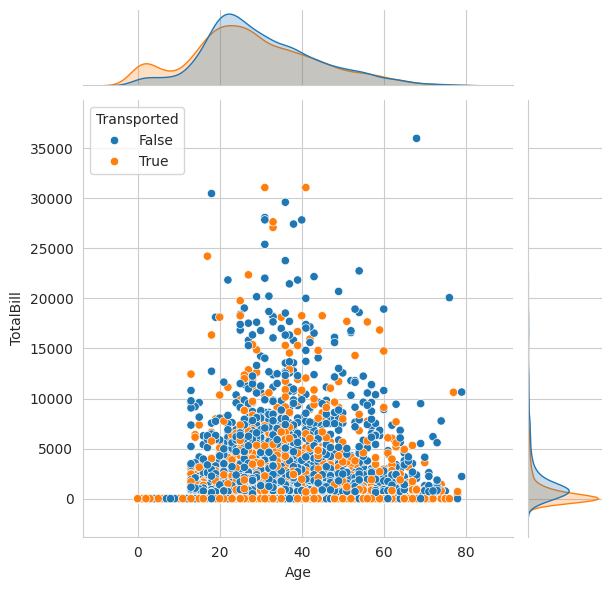

In [478]:
sns.jointplot(data=df_train, x='Age', y='TotalBill', hue='Transported')

Deck

<Axes: xlabel='Deck', ylabel='TotalBill'>

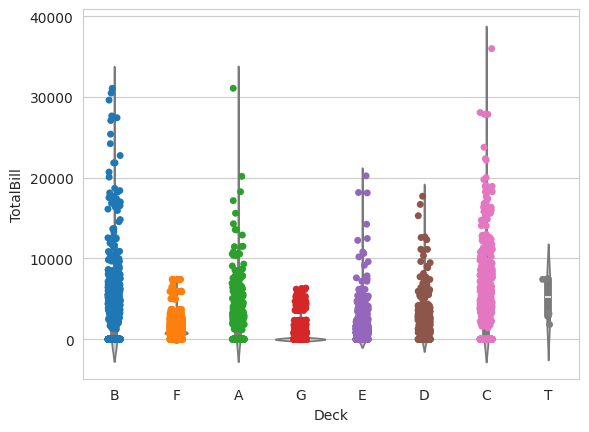

In [479]:
sns.violinplot(data=df_train, x='Deck', y='TotalBill', color='.8')
sns.stripplot(data=df_train, x='Deck', y='TotalBill', hue="Deck", legend=False)

<Axes: xlabel='Deck', ylabel='Age'>

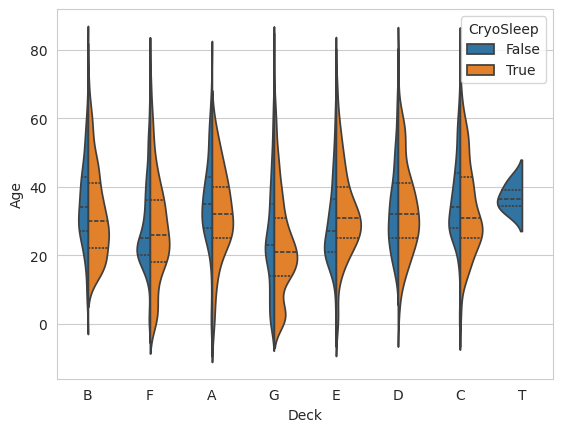

In [480]:
sns.violinplot(data=df_train, x='Deck', y='Age', hue='CryoSleep', split=True, inner='quart')
#VIP
#Transported

<Axes: xlabel='Deck', ylabel='TotalBill'>

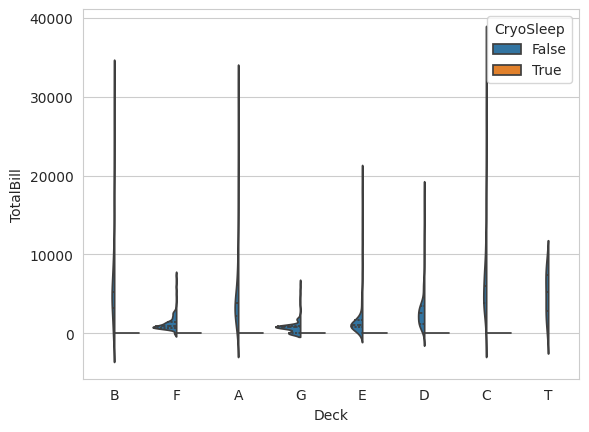

In [481]:
sns.violinplot(data=df_train, x='Deck', y='TotalBill', hue='CryoSleep', split=True, inner='quart')
#VIP
#Transported

# Conclusion

Group analysis by ids

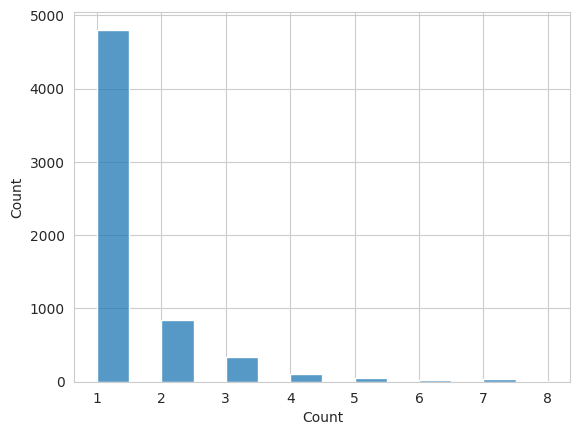

In [482]:
grouped_counts = df_train['GroupNumber'].value_counts().reset_index()
grouped_counts.columns = ['GroupNumber', 'Count']
ax = sns.histplot(data=grouped_counts, x='Count')

And, finally, let's create a correlation heatmap. For this purpose form the func that encodes the dataframe:

In [483]:
def make_label_encoder(data):
    cat_col = data.select_dtypes(['object','bool']).columns
    transformed_df = pd.DataFrame()
    for col in cat_col:
        le = LabelEncoder()
        x = le.fit_transform(data[col])
        transformed_df[col] = x
    numeric_col = data.drop(columns=cat_col)
    return pd.concat([transformed_df,numeric_col],axis=1)

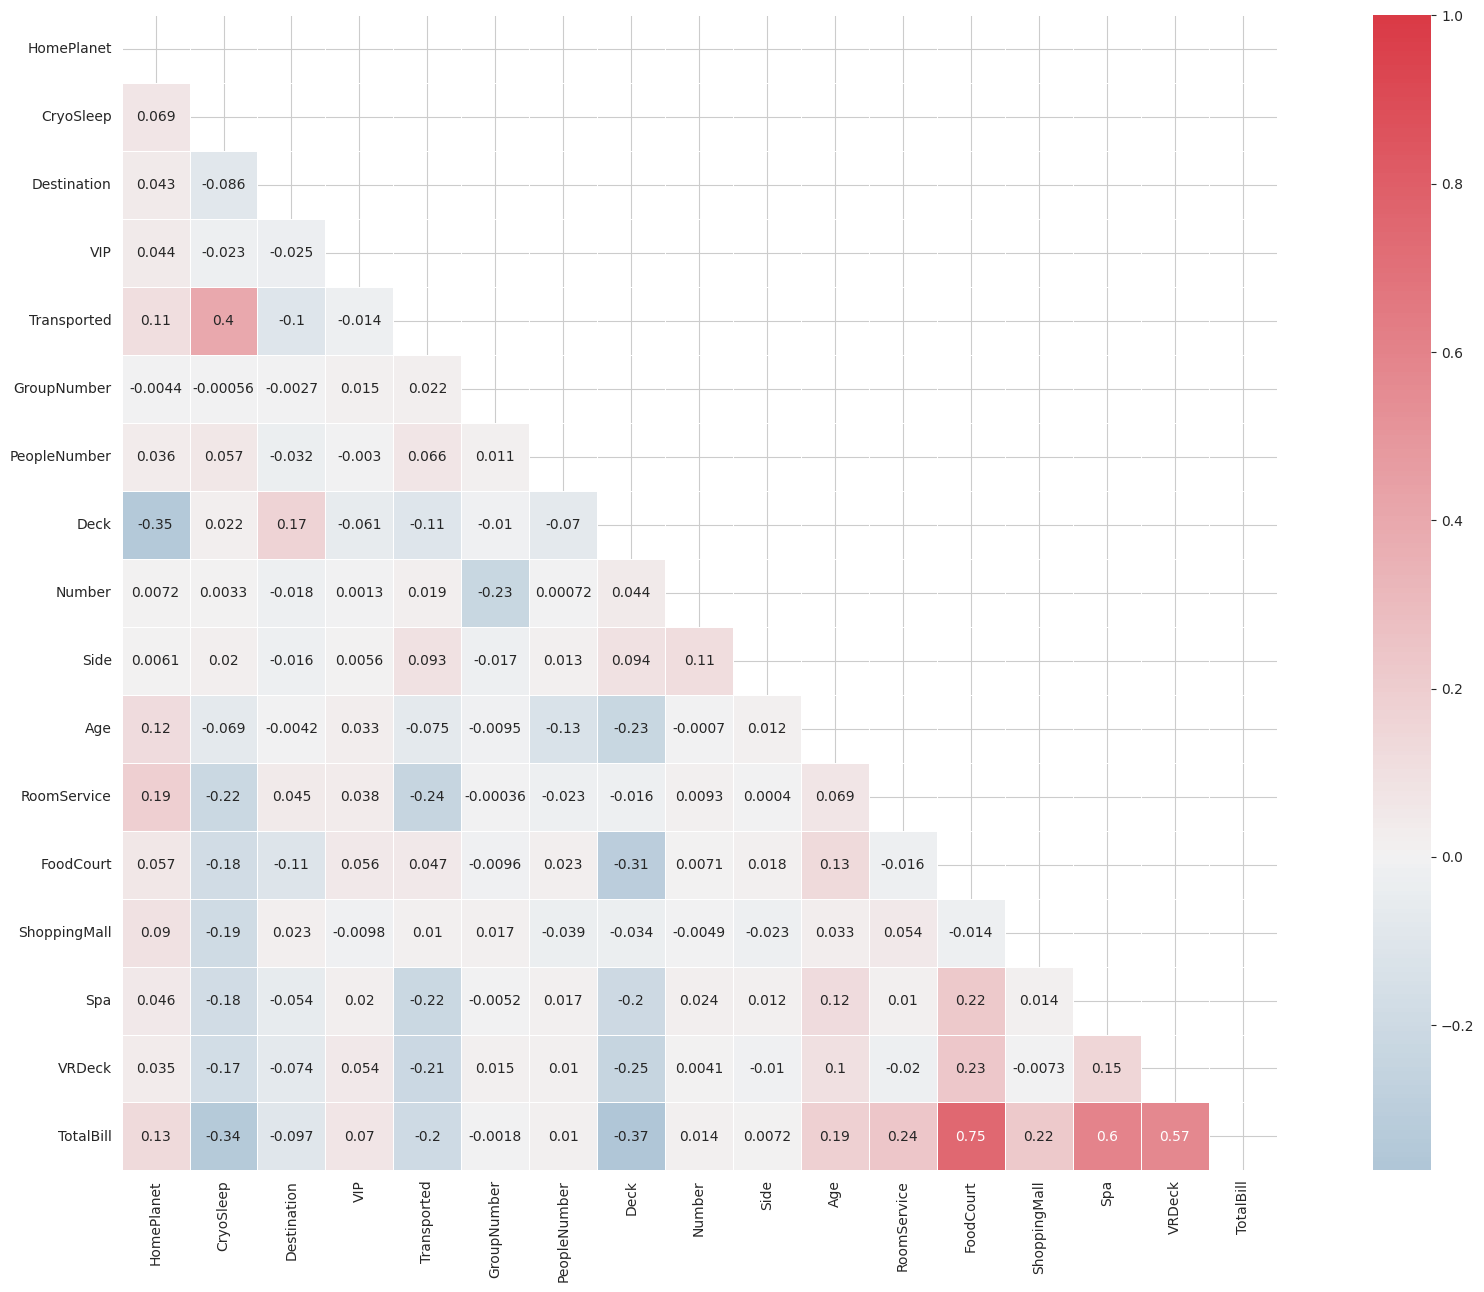

In [484]:
df_train_transformed = make_label_encoder(df_train)
corr = df_train_transformed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, axes = plt.subplots(figsize=(25, 15))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, annot=True)
plt.show()

## Data preparation

For the purpose of X sample preprocessing create dataframe `df_common` that consist of train and test data:

In [485]:
df_train_tmp = df_train.drop(columns=['TotalBill', 'Transported'])
df_train_tmp['Type'] = 'train'

df_test_tmp = df_test.drop(columns=['PassengerId'])
df_test_tmp['Type'] = 'test'

df_common = pd.concat([df_train_tmp, df_test_tmp], ignore_index=True)

In [486]:
df_common.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12682 non-null  object 
 1   CryoSleep     12660 non-null  object 
 2   Destination   12696 non-null  object 
 3   Age           12700 non-null  float64
 4   VIP           12674 non-null  object 
 5   RoomService   12707 non-null  float64
 6   FoodCourt     12681 non-null  float64
 7   ShoppingMall  12664 non-null  float64
 8   Spa           12686 non-null  float64
 9   VRDeck        12702 non-null  float64
 10  GroupNumber   12970 non-null  object 
 11  PeopleNumber  12970 non-null  object 
 12  Deck          12671 non-null  object 
 13  Number        12671 non-null  object 
 14  Side          12671 non-null  object 
 15  Type          12970 non-null  object 
dtypes: float64(6), object(10)
memory usage: 1.6+ MB


Tackle all missing values with the following func:

In [487]:
def imputer_func(col, data, strategy='mean'):
    imp = SimpleImputer(strategy=strategy)
    data[col] = imp.fit_transform(data[[col]]).ravel()
    return data[col]

In [488]:
df_common['HomePlanet'] = imputer_func('HomePlanet', df_common, strategy='most_frequent')
df_common['CryoSleep'] = imputer_func('CryoSleep', df_common, strategy='most_frequent')
df_common['Destination'] = imputer_func('Destination', df_common, strategy='most_frequent')
df_common['Age'] = imputer_func('Age', df_common, strategy='mean')
df_common['VIP'] = imputer_func('VIP', df_common, strategy='most_frequent')
df_common['RoomService'] = imputer_func('RoomService', df_common, strategy='median')
df_common['FoodCourt'] = imputer_func('FoodCourt', df_common, strategy='median')
df_common['ShoppingMall'] = imputer_func('ShoppingMall', df_common, strategy='median')
df_common['Spa'] = imputer_func('Spa', df_common, strategy='median')
df_common['VRDeck'] = imputer_func('VRDeck', df_common, strategy='median')
df_common['Deck'] = imputer_func('Deck', df_common, strategy='most_frequent')
df_common['Number'] = imputer_func('Number', df_common, strategy='most_frequent')
df_common['Side'] = imputer_func('Side', df_common, strategy='most_frequent')

In [489]:
analyze_na(df_common)

,NA count,NA percentage (%)
HomePlanet,0,0.0
CryoSleep,0,0.0
Destination,0,0.0
Age,0,0.0
VIP,0,0.0
RoomService,0,0.0
FoodCourt,0,0.0
ShoppingMall,0,0.0
Spa,0,0.0
VRDeck,0,0.0


Now, we encode string values:

In [490]:
le = LabelEncoder()
columns_to_encode = ['HomePlanet', 'Destination', 'Deck', 'Side', 'Type']
for column in columns_to_encode:
    df_common[column] = le.fit_transform(df_common[column])

In [491]:
df_common.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupNumber,PeopleNumber,Deck,Number,Side,Type
0,1,False,2,39.0,False,0.0,0.0,0.0,0.0,0.0,0001,01,1,0,0,1
1,0,False,2,24.0,False,109.0,9.0,25.0,549.0,44.0,0002,01,5,0,1,1
2,1,False,2,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0003,01,0,0,1,1
3,1,False,2,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0003,02,0,0,1,1
4,0,False,2,16.0,False,303.0,70.0,151.0,565.0,2.0,0004,01,5,1,1,1


Convert `bool` columns to `int` dtype:

In [492]:
columns_to_convert = ['Age', 'VIP', 'CryoSleep', 'GroupNumber', 'PeopleNumber', 'Number']
df_common[columns_to_convert] = df_common[columns_to_convert].apply(lambda x: x.astype(int))

And scale all the values:

In [493]:
scaler = MinMaxScaler()
df_common[df_common.columns] = scaler.fit_transform(df_common[df_common.columns])

As the result we've got the next dataframe:

In [494]:
df_common.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupNumber,PeopleNumber,Deck,Number,Side,Type
0,0.5,0.0,1.0,0.493671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.0,1.0
1,0.0,0.0,1.0,0.303797,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,0.000108,0.000000,0.714286,0.000000,1.0,1.0
2,0.5,0.0,1.0,0.734177,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.000216,0.000000,0.000000,0.000000,1.0,1.0
3,0.5,0.0,1.0,0.417722,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.000216,0.142857,0.000000,0.000000,1.0,1.0
4,0.0,0.0,1.0,0.202532,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,0.000323,0.000000,0.714286,0.000528,1.0,1.0


In [495]:
df_common.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  float64
 1   CryoSleep     12970 non-null  float64
 2   Destination   12970 non-null  float64
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  float64
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  GroupNumber   12970 non-null  float64
 11  PeopleNumber  12970 non-null  float64
 12  Deck          12970 non-null  float64
 13  Number        12970 non-null  float64
 14  Side          12970 non-null  float64
 15  Type          12970 non-null  float64
dtypes: float64(16)
memory usage: 1.6 MB


In [496]:
df_common.describe()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupNumber,PeopleNumber,Deck,Number,Side,Type
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,0.327718,0.353200,0.750732,0.363999,0.021049,0.015242,0.014822,0.007270,0.013465,0.012450,0.499444,0.073070,0.619562,0.312343,0.515035,0.670239
std,0.399927,0.477983,0.405369,0.180217,0.143552,0.044794,0.052596,0.024866,0.049926,0.048426,0.289461,0.148929,0.248839,0.270831,0.499793,0.470144
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.500000,0.253165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.248437,0.000000,0.428571,0.082365,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.341772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.499084,0.000000,0.714286,0.215945,1.000000,1.000000
75%,0.500000,1.000000,1.000000,0.468354,0.000000,0.002984,0.002105,0.000979,0.002231,0.001492,0.746174,0.142857,0.857143,0.523759,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Also define the target label:

In [497]:
target = 'Transported'

And, finally, define train and test samples:

In [498]:
X = df_common[df_common['Type'] == 1] \
    .drop(columns=['Type']) \
    .values
y = df_train[target] \
    .astype(int) \
    .values.reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
X_test = df_common[df_common['Type'] == 0] \
    .drop(columns=['Type']) \
    .values

print(f"X sample: [" + ', '.join(format(x, ".2f") for x in X_train[0]) + "]")
print(f"y sample: [" + ', '.join(format(x, ".2f") for x in y_train[0]) + "]")

X sample: [1.00, 0.00, 1.00, 0.34, 0.00, 0.03, 0.00, 0.02, 0.02, 0.00, 0.64, 0.00, 0.71, 0.60, 1.00]
y sample: [0.00]


In [499]:
df_train = df_train.drop(columns=['TotalBill'])

In [500]:
#
df_train['HomePlanet'] = imputer_func('HomePlanet', df_common, strategy='most_frequent')
df_train['CryoSleep'] = imputer_func('CryoSleep', df_common, strategy='most_frequent')
df_train['Destination'] = imputer_func('Destination', df_common, strategy='most_frequent')
df_train['Age'] = imputer_func('Age', df_common, strategy='mean')
df_train['VIP'] = imputer_func('VIP', df_common, strategy='most_frequent')
df_train['RoomService'] = imputer_func('RoomService', df_common, strategy='median')
df_train['FoodCourt'] = imputer_func('FoodCourt', df_common, strategy='median')
df_train['ShoppingMall'] = imputer_func('ShoppingMall', df_common, strategy='median')
df_train['Spa'] = imputer_func('Spa', df_common, strategy='median')
df_train['VRDeck'] = imputer_func('VRDeck', df_common, strategy='median')
df_train['Deck'] = imputer_func('Deck', df_common, strategy='most_frequent')
df_train['Number'] = imputer_func('Number', df_common, strategy='most_frequent')
df_train['Side'] = imputer_func('Side', df_common, strategy='most_frequent')
#
df_train[columns_to_convert] = df_train[columns_to_convert].apply(lambda x: x.astype(int))
#
df_train_splitted, df_valid_splitted = train_test_split(df_train, test_size=0.25, random_state=42)

#
df_test['HomePlanet'] = imputer_func('HomePlanet', df_common, strategy='most_frequent')
df_test['CryoSleep'] = imputer_func('CryoSleep', df_common, strategy='most_frequent')
df_test['Destination'] = imputer_func('Destination', df_common, strategy='most_frequent')
df_test['Age'] = imputer_func('Age', df_common, strategy='mean')
df_test['VIP'] = imputer_func('VIP', df_common, strategy='most_frequent')
df_test['RoomService'] = imputer_func('RoomService', df_common, strategy='median')
df_test['FoodCourt'] = imputer_func('FoodCourt', df_common, strategy='median')
df_test['ShoppingMall'] = imputer_func('ShoppingMall', df_common, strategy='median')
df_test['Spa'] = imputer_func('Spa', df_common, strategy='median')
df_test['VRDeck'] = imputer_func('VRDeck', df_common, strategy='median')
df_test['Deck'] = imputer_func('Deck', df_common, strategy='most_frequent')
df_test['Number'] = imputer_func('Number', df_common, strategy='most_frequent')
df_test['Side'] = imputer_func('Side', df_common, strategy='most_frequent')
#
df_test[columns_to_convert] = df_test[columns_to_convert].apply(lambda x: x.astype(int))

In [501]:
df_train_splitted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6519 entries, 5623 to 7270
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    6519 non-null   float64
 1   CryoSleep     6519 non-null   int64  
 2   Destination   6519 non-null   float64
 3   Age           6519 non-null   int64  
 4   VIP           6519 non-null   int64  
 5   RoomService   6519 non-null   float64
 6   FoodCourt     6519 non-null   float64
 7   ShoppingMall  6519 non-null   float64
 8   Spa           6519 non-null   float64
 9   VRDeck        6519 non-null   float64
 10  Transported   6519 non-null   bool   
 11  GroupNumber   6519 non-null   int64  
 12  PeopleNumber  6519 non-null   int64  
 13  Deck          6519 non-null   float64
 14  Number        6519 non-null   int64  
 15  Side          6519 non-null   float64
dtypes: bool(1), float64(9), int64(6)
memory usage: 821.2 KB


## Models application

### 1. Gradient Boosting [CatBoost]

In [ ]:
clf = CatBoostClassifier(verbose=False)
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 4, 5, 6],
    'l2_leaf_reg': [1, 3, 5, 7]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X, y)

print("Best params of the CatBoost model:")
print(grid_search.best_estimator_.get_params())

Best params of the CatBoost model:
{'verbose': False, 'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 7, 'learning_rate': 0.01}


In [299]:
clf = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=6, l2_leaf_reg=7, verbose=False)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

print(f'Cross-validation accuracies: {scores}')
print(f'Mean accuracy: {scores.mean()}')

Cross-validation accuracies: [0.81713629 0.80563542 0.8159862  0.81818182 0.80552359]
Mean accuracy: 0.8124926630717096


In [178]:
clf = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=3, verbose=100)
clf.fit(X_train, y_train)

print(clf.get_feature_importance())

0:	learn: 0.6569023	total: 2.61ms	remaining: 2.6s
100:	learn: 0.3978904	total: 229ms	remaining: 2.03s
200:	learn: 0.3633033	total: 447ms	remaining: 1.78s
300:	learn: 0.3420760	total: 989ms	remaining: 2.3s
400:	learn: 0.3270483	total: 1.21s	remaining: 1.81s
500:	learn: 0.3155003	total: 1.43s	remaining: 1.42s
600:	learn: 0.3043698	total: 1.65s	remaining: 1.09s
700:	learn: 0.2942743	total: 1.88s	remaining: 804ms
800:	learn: 0.2844736	total: 2.11s	remaining: 524ms
900:	learn: 0.2757533	total: 2.33s	remaining: 256ms
999:	learn: 0.2671152	total: 3.01s	remaining: 0us
[7.46513201e+00 1.14019435e+01 1.21721654e+00 7.93829140e+00
 5.27736690e-03 9.11558588e+00 6.91356538e+00 3.93944321e+00
 1.15000533e+01 1.06273926e+01 6.47948911e+00 1.02809670e+00
 1.11035511e+01 7.94693146e+00 3.31803044e+00]


In [195]:
y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Current accuracy: {accuracy}\n")
print(f"Classification report:")
print(classification_report(y_val, y_pred))

Current accuracy: 0.8017479300827967

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1082
           1       0.79      0.82      0.81      1092

    accuracy                           0.80      2174
   macro avg       0.80      0.80      0.80      2174
weighted avg       0.80      0.80      0.80      2174



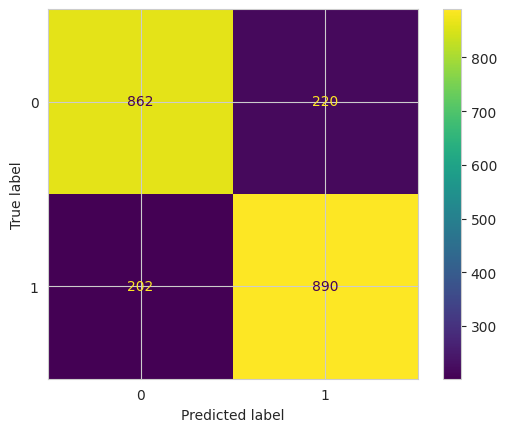

In [145]:
_ = ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val)

In [149]:
y_test = clf.predict(X_test)
y_test = (y_test > 0.5).astype(bool)

output = pd.DataFrame({'PassengerId': df_test['PassengerId'],
                       'Transported': y_test.squeeze()})
output.to_csv('/content/drive/MyDrive/kaggle/spaceship_titanic/submissions/submission_catboost.csv',
              index=False)

### 2. Gradient Boosted Trees [TensorFlow]

In [502]:
ds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_train_splitted, label=target)
ds_valid = tfdf.keras.pd_dataframe_to_tf_dataset(df_valid_splitted, label=target)
ds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_test)

Create the Gradient Boosted Trees Model:

In [516]:
gbt = tfdf.keras.GradientBoostedTreesModel()
gbt.compile(metrics=["accuracy"])
gbt.fit(x=ds_train)

inspector = gbt.make_inspector()
print(f"\nAccuracy: {inspector.evaluation().accuracy}\n")

Use /tmp/tmpt23jcovx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.399370. Found 6519 examples.
Training model...
Model trained in 0:00:01.343884
Compiling model...
Model compiled.

Accuracy: 0.7763975262641907



Visualize this tree-based model:

In [506]:
tfdf.model_plotter.plot_model_in_colab(gbt, tree_idx=0, max_depth=3)

Evaluate the model on the Out of bag (OOB) data and the validation dataset:

Text(0.5, 1.0, 'Accuracy (out-of-bag)')

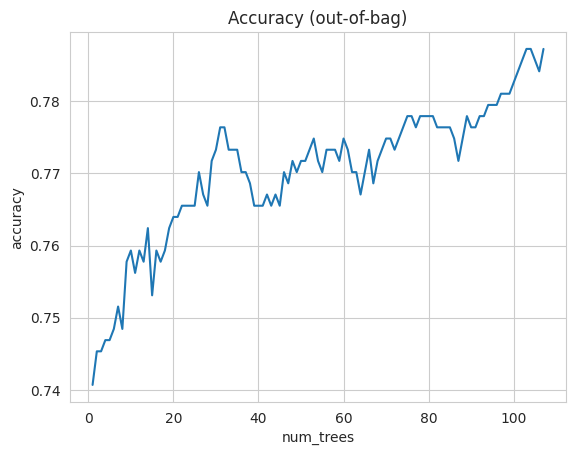

In [507]:
logs = gbt.make_inspector().training_logs()
df_logs = pd.DataFrame({'num_trees': [log.num_trees for log in logs],
                        'accuracy': [log.evaluation.accuracy for log in logs]})
sns.lineplot(data=df_logs, x='num_trees', y='accuracy') \
.set_title('Accuracy (out-of-bag)')

Now, run an evaluation using the validation dataset.

In [520]:
y_pred = gbt.predict(ds_valid)
y_pred = (y_pred > 0.5).astype(bool)
accuracy = accuracy_score(y_val, y_pred)

print(f"\nCurrent accuracy: {accuracy}\n")
print(f"Classification report:")
print(classification_report(y_val, y_pred))

3/3 [==============================] - 3s 1s/step

Current accuracy: 0.7907083716651334

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1082
           1       0.78      0.81      0.79      1092

    accuracy                           0.79      2174
   macro avg       0.79      0.79      0.79      2174
weighted avg       0.79      0.79      0.79      2174



In [523]:
from sklearn.metrics import confusion_matrix

In [529]:
cm = confusion_matrix(y_val, y_pred)
_ = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
# And show it:
plt.show()

Also, we can identify variable importances as `NUM_AS_ROOT`:

In [ ]:
inspector.variable_importances()['NUM_AS_ROOT']

[("CryoSleep" (1; #1), 26.0),
 ("VRDeck" (1; #15), 24.0),
 ("Spa" (1; #13), 17.0),
 ("Side" (4; #12), 9.0),
 ("RoomService" (1; #10), 7.0),
 ("Age" (1; #0), 6.0),
 ("Number" (1; #7), 3.0),
 ("Destination" (4; #3), 1.0),
 ("GroupNumber" (1; #5), 1.0),
 ("PeopleNumber" (1; #9), 1.0)]

Form a submission:

In [ ]:
predictions = gbt.predict(ds_test)
predictions_bool = (predictions > 0.5).astype(bool)

output = pd.DataFrame({'PassengerId': df_test['PassengerId'],
                       'Transported': predictions_bool.squeeze()})
output.to_csv('/content/drive/MyDrive/kaggle/spaceship_titanic/submission_tfdf_gbt.csv',
              index=False)

5/5 [==============================] - 5s 1s/step


### 3. Deep Neural Network [Keras]

In [ ]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
batch_size = 32
dropout = 0.4
epochs = 100
callback = EarlyStopping(monitor='loss', patience=3)

print(f"{'Hyperparameter':<20} {'Value':<10}")
print("-" * 30)
print(f"{'input_dim':<20} {input_dim:<10}")
print(f"{'output_dim':<20} {output_dim:<10}")
print(f"{'batch_size':<20} {batch_size:<10}")
print(f"{'dropout':<20} {dropout:<10}")
print(f"{'epochs':<20} {epochs:<10}")

Hyperparameter       Value     
------------------------------
input_dim            15        
output_dim           1         
batch_size           32        
dropout              0.4       
epochs               100       


In [ ]:
model = Sequential()

model.add(Input(shape=(input_dim,)))

model.add(Dense(256, kernel_initializer=HeNormal()))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(output_dim))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                     │ (None, 256)                 │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_61 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_62 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_63 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_64 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 1)                   │              33 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_65 (Activation)           │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,361 (185.00 KB)

 Trainable params: 47,361 (185.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    callbacks=[callback])

model_history = pd.DataFrame({
    'epochs': 2 * list(range(len(history.history['accuracy']))),
    'type': len(history.history['accuracy']) * ['train'] + len(history.history['accuracy']) * ['validation'],
    'accuracy': history.history['accuracy'] + history.history['val_accuracy'],
    'loss': history.history['loss'] + history.history['val_loss']
})

Epoch 1/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5786 - loss: 0.6963 - val_accuracy: 0.7268 - val_loss: 0.5491
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7063 - loss: 0.5730 - val_accuracy: 0.7226 - val_loss: 0.5337
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7054 - loss: 0.5676 - val_accuracy: 0.7314 - val_loss: 0.5341
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7181 - loss: 0.5586 - val_accuracy: 0.7470 - val_loss: 0.5125
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7305 - loss: 0.5402 - val_accuracy: 0.7456 - val_loss: 0.5014
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7400 - loss: 0.5330 - val_accuracy: 0.7521 - val_loss: 0.4954
Epoch 7/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7482 - loss: 0.5147 - val_accuracy: 0.7502 - val_loss: 0.4749
Epoch 8/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7576 - loss: 0.5055 - val_

Text(0.5, 1.0, 'Loss of the model')

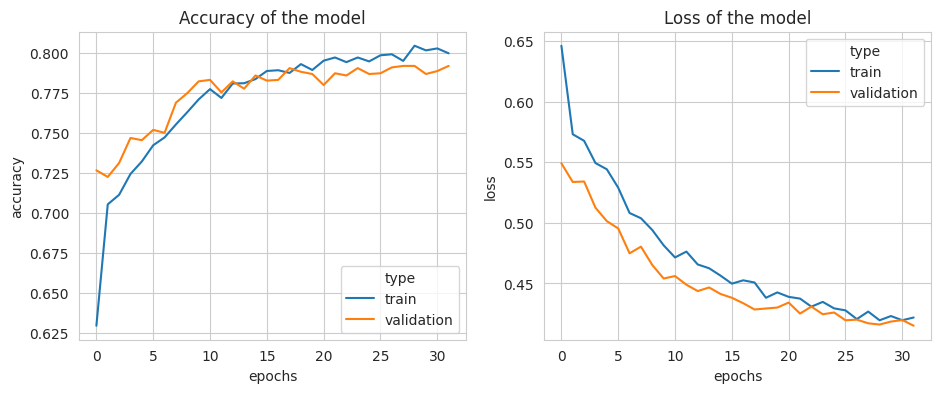

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
sns.lineplot(data=model_history, x='epochs', y='accuracy', hue='type', ax=axes[0]) \
   .set_title("Accuracy of the model")
sns.lineplot(data=model_history, x='epochs', y='loss', hue='type', ax=axes[1]) \
   .set_title("Loss of the model")

In [ ]:
y_test = model.predict(X_test)
y_test = (y_test > 0.5).astype(bool)

output = pd.DataFrame({'PassengerId': df_test['PassengerId'],
                       'Transported': y_test.squeeze()})
output.to_csv('/content/drive/MyDrive/kaggle/spaceship_titanic/submissions/submission_dnn_256_128_64_32_HeNormal_d04.csv',
              index=False)

134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


## References

https://www.kaggle.com/code/ritzig/eda-using-seaborn-missing-value-feature-selection#Missing-Value-Handling

https://www.kaggle.com/code/gusthema/spaceship-titanic-with-tfdf